<h3>Reference to IPAC Presentation (slide 16): Setting up a quantum image from a classical 2x2px image: (I0,I1,I2,I3)</h3>   

c0:
0.0
c1:
0.37219211070445407
c2:
0.5582881660566811
c3:
0.7414764705440295


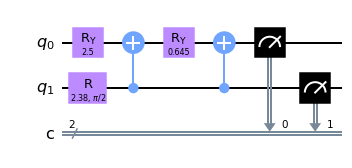

In [1]:
# Initialization
# Imports required :
import numpy as np
from math import pi, sqrt
# Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit import(
  execute,
  BasicAer)
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
# Import of graphic tools
from qiskit.visualization import plot_histogram, array_to_latex

#Implementation of the 2x2px image (I0,I1,I2,I3)
I0 = 0
I1 = 128
I2 = 192
I3 = 255

#Passage to the quantum image
c0 = I0/sqrt(I0**2+I1**2+I2**2+I3**2)
c1 = I1/sqrt(I0**2+I1**2+I2**2+I3**2)
c2 = I2/sqrt(I0**2+I1**2+I2**2+I3**2)
c3 = I3/sqrt(I0**2+I1**2+I2**2+I3**2)

print("c0:")
print(c0)
print("c1:")
print(c1)
print("c2:")
print(c2)
print("c3:")
print(c3)

#Preparation of the quantum image state via the implementation of a quantum circuit: 
qc = QuantumCircuit(2, 2)
qc.ry(2.5,0)
qc.r(2.38,pi/2,1)
qc.cx(1,0)
qc.ry(0.645,0)
qc.cx(1,0)

# Mesure
qc.measure([0,1], [0,1])
simulator = QasmSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
# Display of the circuit:
qc.draw('mpl')

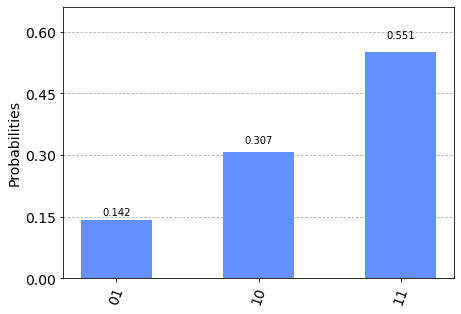

In [2]:
# Display of the corresponding histogram
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)

<h3>Refer to IPAC Presentation (slide 19): Implementation and application of the QHED algorithm on a simplified image:
</h3> 

In [3]:
# Uncomment and install as required for the following:
# pip install ipywidgets 

In [4]:
# Import standard Qiskit libraries (if not already imported)
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Autres imports nécessaires
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

<h4><u> 1. Initialization: simplified image implementation</u></h4> 

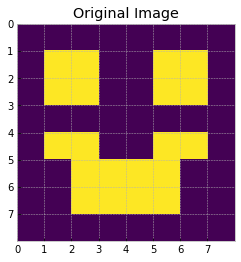

In [5]:
#Initialization

# Setting up an 8x8 binary image represented as a numpy array
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 0, 0, 1, 1, 0],
                  [0, 1, 1, 0, 0, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 0, 0, 1, 1, 0],
                  [0, 0, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Function to plot the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

<h4><u> 2. Transformation of our classical image into a quantum image using the QPIE method:</u></h4>. 

In [6]:
# Implementation of a function to convert raw pixel values of an image into probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create a normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the values of the anchored pixels in amplitude
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical : Transpose the original image
image_norm_v = amplitude_encode(image.T)




<h4><u> 3. Implementation of the QHED algorithm</u></h4>

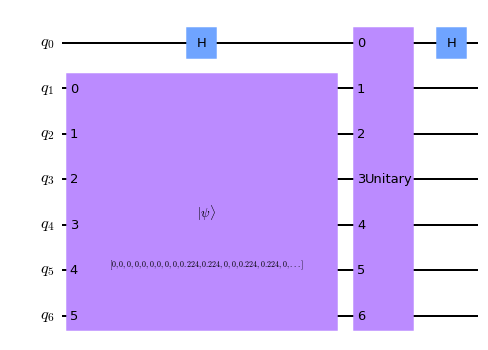

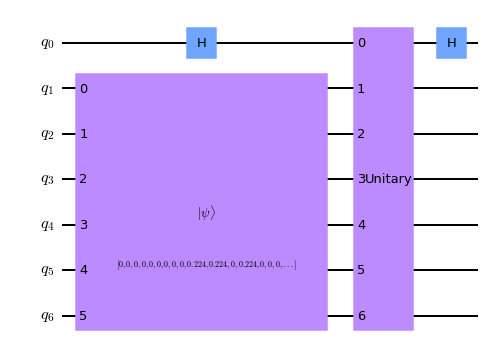

In [7]:
# Initialize a global variable: total_qb for the number of qubits
data_qb = 6
# anc_qb represents the auxiliary qubit:
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the permutation amplitude unit operator 
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

# Create the circuit for horizontal scanning
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scanning
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine the two circuits into one list
circ_list = [qc_h, qc_v]

<h4><u> 4. Simulation</u></h4> 

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

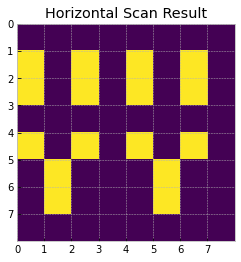

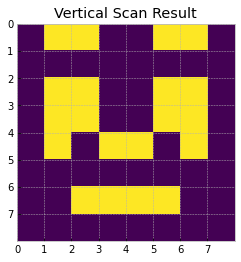

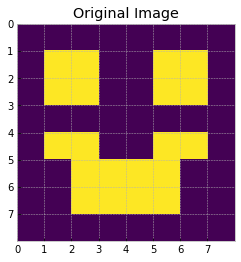

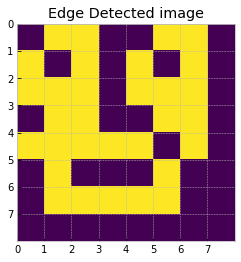

In [8]:
# Circuit simulation
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(sv_v[:30], max_size=30))

# Classic post-processing for output plotting

# Define a lambda function for thresholding in binary values
threshold = lambda amp: (amp > 1e-5 or amp < -1e-15)

# Select the odd states from the raw state vector and reshape the column vector of size 64 into an 8x8 matrix.
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal Scan Result')
plot_image(edge_scan_v, 'Vertical Scan Result')

# Combine the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Tracing the original images and the images detected by the edges.
plot_image(image, 'Original Image')
plot_image(edge_scan_sim, 'Edge Detected image')

<h3>Refer to IPAC Presentation (slide 20): Using the QHED algorithm implemented on a real image</h3>. 

In [9]:
# Uncomment and install as required for the following:
# pip install scikit-image

In [10]:
# Implementation of a function to display the progress of the following program
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

Raw Image datatype: float32
Raw Image info: (256, 256, 4)
Raw Image datatype: float32
Image shape (numpy array): (256, 256)


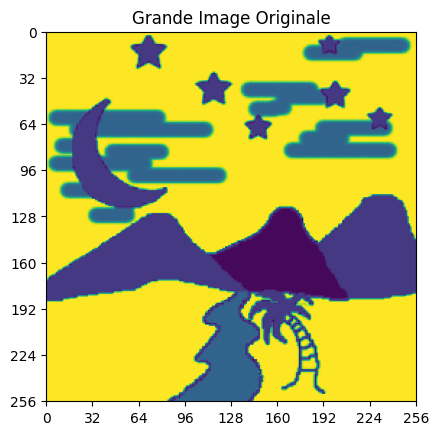

Detection de contour de l'image:
Progress: |██████████████████████████████████████████████████| 100.0% Complete


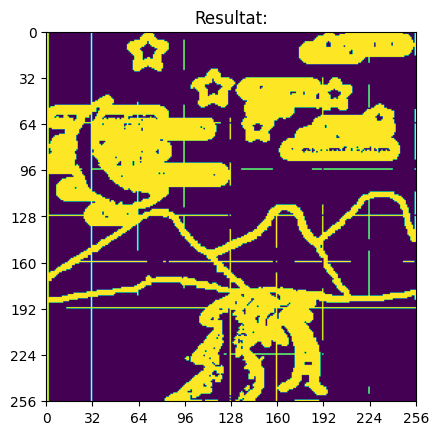

(256, 256)


In [19]:
# Imports and initializations
from skimage.transform import resize
from PIL import Image
style.use('default')
image_size = 256       # width and height of the original image
image_crop_size = 32   # width and height of each part of the cropped image to apply QHED successively


# Step 1: Loading the image
im = plt.imread('images/edge_detection_input.jpg')
res = resize(im, (256, 256))
image_raw = np.array(res)
print('Raw Image datatype:', image_raw.dtype)
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Step 2: Convert the RBG component of the image into a B&W image, as a numpy array (uint8)
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
image = np.array(image)
print('Image shape (numpy array):', image.shape)

# Displaying the original image
plt.title('Grande Image Originale')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

print("Detection de contour de l'image:")
#Display of a progress bar:
printProgressBar(0, 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
# Step 3: Decompose the image into 64 images of size 32x32 px.
for l in range(8):
    #Decomposition of the image in 8 vertical strips 32x256px
    for k in range(8):
        #For each "vertical strip" image : recovery of the k^th image 32x32px
        image = []
        for i in range(l*image_crop_size, (l+1)*image_crop_size):
            image.append([])
            for j in range(k*image_crop_size, (k+1)*image_crop_size):
                image[i-l*image_crop_size].append(image_raw[i][j][0]/31)
        image = np.array(image)
        
        # Step 4.1:
        #Application of the previously implemented QHED algorithm on the cropped image: resumption of the previous code from step b)
        
        # > Step b):
        # Get the values of the anchored pixels in amplitude
        # Horizontal: Original image
        image_norm_h = amplitude_encode(image)
        # Vertical : Transpose the original image
        image_norm_v = amplitude_encode(image.T)

        # Step c):
        # Initialize a global variable: total_qb for the number of qubits
        data_qb = 10
        # anc_qb represents the auxiliary qubit:
        anc_qb = 1
        total_qb = data_qb + anc_qb
        # Initialize the amplitude permutation operator
        D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
        # Create the circuit for the horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)
        # Create the circuit for vertical scanning
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)
        # Combine the two circuits  into one list
        circ_list = [qc_h, qc_v]
    
        # Step d):
        # Circuit simulation
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)
        # Classical post-processing for output plotting
        # Define a lambda function for thresholding into binary values
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
        # Select the odd states from the raw state vector and reshape the column vector of size 64 into a 32x32 matrix.
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

        # Combine the horizontal and vertical component of the result
        edge_scan_sim = edge_scan_h | edge_scan_v

        # Step 4.2:
        # Reconstruction of a 256x256px image from the image detection performed on the 64 32x32px images representing the original image:
        # concatenation of the k = 0,...,7 32x32px "edge sccaned" images into a 256x32px band image. 
        if k == 0:
            line_image = edge_scan_sim
        else:
            line_image = np.concatenate((line_image,edge_scan_sim),axis=1)
         # display of a progress bar:
        printProgressBar((l+1)*(k+1), 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    # concatenation of l = 0,...,7 image-horizontal bands "edge scanned" 256x32px into one image 256x256px "edge sccaned". 
    if l == 0:
        final_image = line_image
    else:
        final_image = np.concatenate((final_image,line_image),axis=0)

# step 5:
plt.title('Resultat:')
plt.xticks(range(0, final_image.shape[0]+1, 32))
plt.yticks(range(0, final_image.shape[1]+1, 32))
plt.imshow(final_image, extent=[0, final_image.shape[0], final_image.shape[1], 0], cmap='viridis')
plt.show()
print(final_image.shape)

Raw Image datatype: float64
Raw Image info: (256, 256, 4)
Raw Image datatype: float64
Image shape (numpy array): (256, 256)


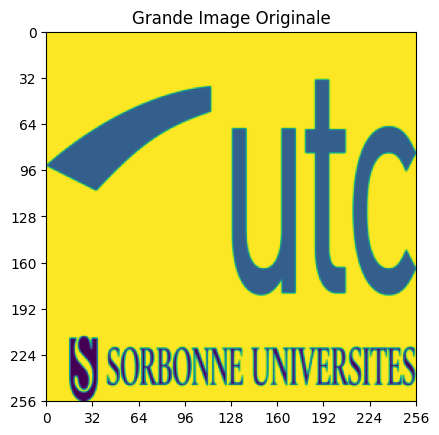

Detection de contour de l'image:
Progress: |██████████████████████████████████████████████████| 100.0% Complete


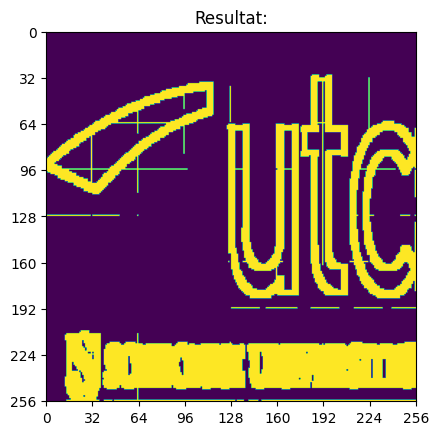

(256, 256)


In [18]:
# Imports and initializations
from skimage.transform import resize
from PIL import Image
style.use('default')
image_size = 256       # width and height of the original image
image_crop_size = 32   # width and height of each part of the cropped image to apply QHED successively


# Step 1: Loading the image
im = plt.imread('images/UTC.jpg')
res = resize(im, (256, 256))
image_raw = np.array(res)
print('Raw Image datatype:', image_raw.dtype)
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Step 2: Convert the RBG component of the image into a B&W image, as a numpy array (uint8)
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
image = np.array(image)
print('Image shape (numpy array):', image.shape)

# Displaying the original image
plt.title('Grande Image Originale')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

print("Detection de contour de l'image:")
#Display of a progress bar:
printProgressBar(0, 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
# Step 3: Decompose the image into 64 images of size 32x32 px.
for l in range(8):
    #Decomposition of the image in 8 vertical strips 32x256px
    for k in range(8):
        #For each "vertical strip" image : recovery of the k^th image 32x32px
        image = []
        for i in range(l*image_crop_size, (l+1)*image_crop_size):
            image.append([])
            for j in range(k*image_crop_size, (k+1)*image_crop_size):
                image[i-l*image_crop_size].append(image_raw[i][j][0]/31)
        image = np.array(image)
        
        # Step 4.1:
        #Application of the previously implemented QHED algorithm on the cropped image: resumption of the previous code from step b)
        
        # > Step b):
        # Get the values of the anchored pixels in amplitude
        # Horizontal: Original image
        image_norm_h = amplitude_encode(image)
        # Vertical : Transpose the original image
        image_norm_v = amplitude_encode(image.T)

        # Step c):
        # Initialize a global variable: total_qb for the number of qubits
        data_qb = 10
        # anc_qb represents the auxiliary qubit:
        anc_qb = 1
        total_qb = data_qb + anc_qb
        # Initialize the amplitude permutation operator
        D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
        # Create the circuit for the horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)
        # Create the circuit for vertical scanning
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)
        # Combine the two circuits  into one list
        circ_list = [qc_h, qc_v]
    
        # Step d):
        # Circuit simulation
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)
        # Classical post-processing for output plotting
        # Define a lambda function for thresholding into binary values
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
        # Select the odd states from the raw state vector and reshape the column vector of size 64 into a 32x32 matrix.
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

        # Combine the horizontal and vertical component of the result
        edge_scan_sim = edge_scan_h | edge_scan_v

        # Step 4.2:
        # Reconstruction of a 256x256px image from the image detection performed on the 64 32x32px images representing the original image:
        # concatenation of the k = 0,...,7 32x32px "edge sccaned" images into a 256x32px band image. 
        if k == 0:
            line_image = edge_scan_sim
        else:
            line_image = np.concatenate((line_image,edge_scan_sim),axis=1)
         # display of a progress bar:
        printProgressBar((l+1)*(k+1), 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    # concatenation of l = 0,...,7 image-horizontal bands "edge scanned" 256x32px into one image 256x256px "edge sccaned". 
    if l == 0:
        final_image = line_image
    else:
        final_image = np.concatenate((final_image,line_image),axis=0)

# step 5:
plt.title('Resultat:')
plt.xticks(range(0, final_image.shape[0]+1, 32))
plt.yticks(range(0, final_image.shape[1]+1, 32))
plt.imshow(final_image, extent=[0, final_image.shape[0], final_image.shape[1], 0], cmap='viridis')
plt.show()
print(final_image.shape)

Raw Image datatype: float64
Raw Image info: (256, 256, 3)
Raw Image datatype: float64
Image shape (numpy array): (256, 256)


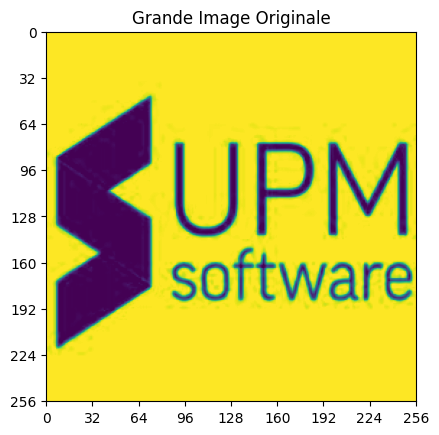

Detection de contour de l'image:
Progress: |██████████████████████████████████████████████████| 100.0% Complete


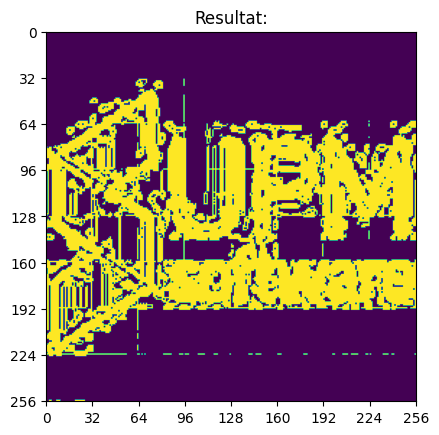

(256, 256)


In [11]:
# Imports and initializations
from skimage.transform import resize
from PIL import Image
style.use('default')
image_size = 256       # width and height of the original image
image_crop_size = 32   # width and height of each part of the cropped image to apply QHED successively


# Step 1: Loading the image
im = plt.imread('images/UTC.jpg')
res = resize(im, (256, 256))
image_raw = np.array(res)
print('Raw Image datatype:', image_raw.dtype)
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Step 2: Convert the RBG component of the image into a B&W image, as a numpy array (uint8)
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
image = np.array(image)
print('Image shape (numpy array):', image.shape)

# Displaying the original image
plt.title('Grande Image Originale')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

print("Detection de contour de l'image:")
#Display of a progress bar:
printProgressBar(0, 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
# Step 3: Decompose the image into 64 images of size 32x32 px.
for l in range(8):
    #Decomposition of the image in 8 vertical strips 32x256px
    for k in range(8):
        #For each "vertical strip" image : recovery of the k^th image 32x32px
        image = []
        for i in range(l*image_crop_size, (l+1)*image_crop_size):
            image.append([])
            for j in range(k*image_crop_size, (k+1)*image_crop_size):
                image[i-l*image_crop_size].append(image_raw[i][j][0]/31)
        image = np.array(image)
        
        # Step 4.1:
        #Application of the previously implemented QHED algorithm on the cropped image: resumption of the previous code from step b)
        
        # > Step b):
        # Get the values of the anchored pixels in amplitude
        # Horizontal: Original image
        image_norm_h = amplitude_encode(image)
        # Vertical : Transpose the original image
        image_norm_v = amplitude_encode(image.T)

        # Step c):
        # Initialize a global variable: total_qb for the number of qubits
        data_qb = 10
        # anc_qb represents the auxiliary qubit:
        anc_qb = 1
        total_qb = data_qb + anc_qb
        # Initialize the amplitude permutation operator
        D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
        # Create the circuit for the horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)
        # Create the circuit for vertical scanning
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)
        # Combine the two circuits  into one list
        circ_list = [qc_h, qc_v]
    
        # Step d):
        # Circuit simulation
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)
        # Classical post-processing for output plotting
        # Define a lambda function for thresholding into binary values
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
        # Select the odd states from the raw state vector and reshape the column vector of size 64 into a 32x32 matrix.
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

        # Combine the horizontal and vertical component of the result
        edge_scan_sim = edge_scan_h | edge_scan_v

        # Step 4.2:
        # Reconstruction of a 256x256px image from the image detection performed on the 64 32x32px images representing the original image:
        # concatenation of the k = 0,...,7 32x32px "edge sccaned" images into a 256x32px band image. 
        if k == 0:
            line_image = edge_scan_sim
        else:
            line_image = np.concatenate((line_image,edge_scan_sim),axis=1)
         # display of a progress bar:
        printProgressBar((l+1)*(k+1), 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    # concatenation of l = 0,...,7 image-horizontal bands "edge scanned" 256x32px into one image 256x256px "edge sccaned". 
    if l == 0:
        final_image = line_image
    else:
        final_image = np.concatenate((final_image,line_image),axis=0)

# step 5:
plt.title('Resultat:')
plt.xticks(range(0, final_image.shape[0]+1, 32))
plt.yticks(range(0, final_image.shape[1]+1, 32))
plt.imshow(final_image, extent=[0, final_image.shape[0], final_image.shape[1], 0], cmap='viridis')
plt.show()
print(final_image.shape)